In [170]:
import pandas as pd
import os
import shutil
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
from IPython.display import display, Audio
import librosa
import librosa.display
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [171]:
#dividing to test, validation and training set
DATASET_AUDIO_PATH = "Data/genres_original/"

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

SHUFFLE_SEED = 43
VALID_and_TEST_SPLIT = 0.2
VALID_SPLIT = 0.5


BATCH_SIZE = 128
EPOCHS = 100
SAMPLING_RATE = 16000

audio_paths = [] # list of paths for every audio sample
labels = [] # classification
features = []

for index, name in enumerate(class_names):
    dir_path = Path(DATASET_AUDIO_PATH)/name
    for filepath in os.listdir(dir_path):
        if filepath.endswith(".wav"):
            data = extract_features(os.path.join(dir_path, filepath))
            features.append([None, data, name])


features_df = pd.DataFrame(features, columns=["file", "feature", "class_label"])

Our class names: ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [172]:
print(features_df)

# 80:10:10
# Split into training, validation and test
X = np.array(features_df.feature.tolist())
y = np.array(features_df.class_label.tolist())

le = LabelEncoder()
yy = le.fit_transform(y)

x_train, x_test_valid, y_train, y_test_valid = train_test_split(X, yy, test_size=0.2, shuffle=True, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_test_valid,  y_test_valid, test_size=0.5, shuffle=True, random_state=42)

def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type="kaiser_fast")
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccscaled = np.mean(mfccs.T, axis=0)
    
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None
    
    return mfccscaled



     file                                            feature class_label
0    None  [-113.57065, 121.57179, -19.168142, 42.36642, ...       blues
1    None  [-207.5017, 123.991264, 8.955127, 35.877647, 2...       blues
2    None  [-90.722595, 140.4463, -29.09389, 31.684334, -...       blues
3    None  [-199.5442, 150.0909, 5.6626782, 26.85908, 1.7...       blues
4    None  [-160.3377, 126.219635, -35.58781, 22.148071, ...       blues
5    None  [-177.77425, 118.20548, -17.56588, 30.762398, ...       blues
6    None  [-190.05237, 130.28908, -36.369534, 33.029034,...       blues
7    None  [-179.34714, 136.46901, -26.673138, 39.98424, ...       blues
8    None  [-121.363945, 122.50668, -14.738196, 46.131065...       blues
9    None  [-213.23999, 115.1656, -11.693431, 39.014275, ...       blues
10   None  [-173.7925, 137.1867, -23.724049, 26.978432, -...       blues
11   None  [-287.92374, 124.01875, 5.469892, 33.65741, 1....       blues
12   None  [-207.22331, 132.83055, -15.4288435, 60.

In [173]:
# model

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical


num_classes = 10
y_train = to_categorical(y_train, num_classes=num_classes)
y_valid = to_categorical(y_valid, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

model = Sequential()

model.add(Dense(128, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


In [174]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 128)               5248      
_________________________________________________________________
dropout_50 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_51 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_79 (Dense)             (None, 10)                650       
Total params: 14,154
Trainable params: 14,154
Non-trainable params: 0
_________________________________________________________________


In [175]:
from keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epochs = 100
batch_size = 16

checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", verbose=1, save_best_only=True)

start = datetime.now()

H = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(x_valid, y_valid), 
          callbacks=[checkpointer], verbose=1)


train_score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", train_score[1])

valid_score = model.evaluate(x_valid, y_valid, verbose=1)
print("Valid Accuracy: ", valid_score[1])




Train on 799 samples, validate on 100 samples
Epoch 1/100
799/799 [==============================] - 0s 236us/step - loss: 12.6344 - accuracy: 0.1327 - val_loss: 2.2352 - val_accuracy: 0.3600

Epoch 00001: val_loss improved from inf to 2.23523, saving model to best_weights.hdf5
Epoch 2/100
799/799 [==============================] - 0s 82us/step - loss: 4.8056 - accuracy: 0.1965 - val_loss: 1.8941 - val_accuracy: 0.3700

Epoch 00002: val_loss improved from 2.23523 to 1.89405, saving model to best_weights.hdf5
Epoch 3/100
799/799 [==============================] - 0s 84us/step - loss: 2.8004 - accuracy: 0.2215 - val_loss: 2.0704 - val_accuracy: 0.2200

Epoch 00003: val_loss did not improve from 1.89405
Epoch 4/100
799/799 [==============================] - 0s 80us/step - loss: 2.2951 - accuracy: 0.2453 - val_loss: 2.0545 - val_accuracy: 0.2500

Epoch 00004: val_loss did not improve from 1.89405
Epoch 5/100
799/799 [==============================] - 0s 82us/step - loss: 2.2032 - accuracy:

799/799 [==============================] - 0s 77us/step - loss: 1.1136 - accuracy: 0.6033 - val_loss: 1.1694 - val_accuracy: 0.6000

Epoch 00038: val_loss improved from 1.17016 to 1.16943, saving model to best_weights.hdf5
Epoch 39/100
799/799 [==============================] - 0s 81us/step - loss: 1.0843 - accuracy: 0.6008 - val_loss: 1.1253 - val_accuracy: 0.6700

Epoch 00039: val_loss improved from 1.16943 to 1.12533, saving model to best_weights.hdf5
Epoch 40/100
799/799 [==============================] - 0s 75us/step - loss: 1.1105 - accuracy: 0.5895 - val_loss: 1.1309 - val_accuracy: 0.6600

Epoch 00040: val_loss did not improve from 1.12533
Epoch 41/100
799/799 [==============================] - 0s 76us/step - loss: 1.0178 - accuracy: 0.6258 - val_loss: 1.1657 - val_accuracy: 0.6700

Epoch 00041: val_loss did not improve from 1.12533
Epoch 42/100
799/799 [==============================] - 0s 74us/step - loss: 1.0582 - accuracy: 0.6245 - val_loss: 1.1550 - val_accuracy: 0.6700

E

799/799 [==============================] - 0s 75us/step - loss: 0.6255 - accuracy: 0.7810 - val_loss: 1.2178 - val_accuracy: 0.6600

Epoch 00079: val_loss did not improve from 1.10501
Epoch 80/100
799/799 [==============================] - 0s 79us/step - loss: 0.6669 - accuracy: 0.7685 - val_loss: 1.2005 - val_accuracy: 0.6700

Epoch 00080: val_loss did not improve from 1.10501
Epoch 81/100
799/799 [==============================] - 0s 71us/step - loss: 0.5892 - accuracy: 0.7810 - val_loss: 1.2293 - val_accuracy: 0.7100

Epoch 00081: val_loss did not improve from 1.10501
Epoch 82/100
799/799 [==============================] - 0s 77us/step - loss: 0.5960 - accuracy: 0.7672 - val_loss: 1.2737 - val_accuracy: 0.6500

Epoch 00082: val_loss did not improve from 1.10501
Epoch 83/100
799/799 [==============================] - 0s 74us/step - loss: 0.5878 - accuracy: 0.7885 - val_loss: 1.2071 - val_accuracy: 0.6700

Epoch 00083: val_loss did not improve from 1.10501
Epoch 84/100
799/799 [======

In [176]:
test_loss, test_acc  = model.evaluate(x_test, y_test, batch_size=128)
print("The test loss is :",test_loss, "\nThe test accuracy is :",test_acc)

100/100 [==============================] - 0s 10us/step
The test loss is : 1.5323725938796997 
The test accuracy is : 0.6600000262260437


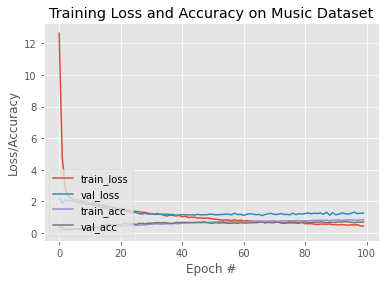

In [177]:
N = 100
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Music Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")